In [ ]:
import random
import numpy as np
import torch 

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
set_seed(42)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.determinstic = True

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [ ]:
device = get_default_device()
device

device(type='cuda')

In [ ]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [ ]:
%matplotlib inline
# python libraties
import os, cv2,itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
from glob import glob
from PIL import Image

# pytorch libraries
import torch
from torch import optim,nn
from torch.autograd import Variable
from torch.utils.data import DataLoader,Dataset, WeightedRandomSampler
from torchvision import models,transforms

# sklearn libraries
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report


In [ ]:
from google.colab import drive
#drive.mount('content/drive/My_Drive/Colab_Notebook')
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pwd

/content


In [ ]:
%cd '/content/drive/My Drive/Colab Notebooks/dataverse_files'

/content/drive/My Drive/Colab Notebooks/dataverse_files


In [ ]:
!ls

HAM10000_images_part_1	HAM10000_images_part_2	HAM10000_metadata  Train.csv


In [ ]:
os.getcwd()

'/content/drive/My Drive/Colab Notebooks/dataverse_files'

In [ ]:
data_dir = '.'
all_image_path = glob(os.path.join(data_dir, '*', '*.jpg'))


In [ ]:
len(all_image_path)

10015

In [ ]:
imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x for x in all_image_path}
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

 Actinic keratoses and intraepithelial carcinoma / Bowen's disease (akiec), basal cell carcinoma (bcc), benign keratosis-like lesions (solar lentigines / seborrheic keratoses and lichen-planus like keratoses, bkl), dermatofibroma (df), melanoma (mel), melanocytic nevi (nv) and vascular lesions (angiomas, angiokeratomas, pyogenic granulomas and hemorrhage, vasc).

In [ ]:
#### the function bellow normalize the images -> for all datset BUT I DESIDED TO NOT USE IT 

In [ ]:
def compute_img_mean_std(image_paths):
    """
        computing the mean and std of three channel on the whole dataset,
        first we should normalize the image from 0-255 to 0-1
    """

    img_h, img_w = 224, 224
    imgs = []
    means, stdevs = [], []

    for i in tqdm(range(len(image_paths))):
        img = cv2.imread(image_paths[i])
        img = cv2.resize(img, (img_h, img_w))
        imgs.append(img)

    imgs = np.stack(imgs, axis=3)
    print(imgs.shape)

    imgs = imgs.astype(np.float32) / 255.

    for i in range(3):
        pixels = imgs[:, :, i, :].ravel()  # resize to one row
        means.append(np.mean(pixels))
        stdevs.append(np.std(pixels))

    means.reverse()  # BGR --> RGB
    stdevs.reverse()

    print("normMean = {}".format(means))
    print("normStd = {}".format(stdevs))
    return means,stdevs

In [ ]:
#norm_mean,norm_std = compute_img_mean_std(all_image_path)

 91%|█████████▏| 9161/10015 [1:00:39<17:13,  1.21s/it]

In [ ]:
#norm_mean,norm_std

In [ ]:
df_original = pd.read_csv(os.path.join(data_dir, 'HAM10000_metadata'))
df_original['path'] = df_original['image_id'].map(imageid_path_dict.get)
df_original['cell_type'] = df_original['dx'].map(lesion_type_dict.get)
df_original['cell_type_idx'] = pd.Categorical(df_original['cell_type']).codes
df_original.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset,path,cell_type,cell_type_idx
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,vidir_modern,./HAM10000_images_part_1/ISIC_0027419.jpg,Benign keratosis-like lesions,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,vidir_modern,./HAM10000_images_part_1/ISIC_0025030.jpg,Benign keratosis-like lesions,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,vidir_modern,./HAM10000_images_part_1/ISIC_0026769.jpg,Benign keratosis-like lesions,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,vidir_modern,./HAM10000_images_part_1/ISIC_0025661.jpg,Benign keratosis-like lesions,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,vidir_modern,./HAM10000_images_part_2/ISIC_0031633.jpg,Benign keratosis-like lesions,2


In [ ]:
# this will tell us how many images are associated with each lesion_id
df_undup = df_original.groupby('lesion_id').count()
# now we filter out lesion_id's that have only one image associated with it
df_undup = df_undup[df_undup['image_id'] == 1]
df_undup.reset_index(inplace=True)
df_undup.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset,path,cell_type,cell_type_idx
0,HAM_0000001,1,1,1,1,1,1,1,1,1,1
1,HAM_0000003,1,1,1,1,1,1,1,1,1,1
2,HAM_0000004,1,1,1,1,1,1,1,1,1,1
3,HAM_0000007,1,1,1,1,1,1,1,1,1,1
4,HAM_0000008,1,1,1,1,1,1,1,1,1,1


In [ ]:
# here we identify lesion_id's that have duplicate images and those that have only one image.
def get_duplicates(x):
    unique_list = list(df_undup['lesion_id'])
    if x in unique_list:
        return 'unduplicated'
    else:
        return 'duplicated'

# create a new colum that is a copy of the lesion_id column
df_original['duplicates'] = df_original['lesion_id']
# apply the function to this new column
df_original['duplicates'] = df_original['duplicates'].apply(get_duplicates)
df_original.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset,path,cell_type,cell_type_idx,duplicates
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,vidir_modern,./HAM10000_images_part_1/ISIC_0027419.jpg,Benign keratosis-like lesions,2,duplicated
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,vidir_modern,./HAM10000_images_part_1/ISIC_0025030.jpg,Benign keratosis-like lesions,2,duplicated
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,vidir_modern,./HAM10000_images_part_1/ISIC_0026769.jpg,Benign keratosis-like lesions,2,duplicated
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,vidir_modern,./HAM10000_images_part_1/ISIC_0025661.jpg,Benign keratosis-like lesions,2,duplicated
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,vidir_modern,./HAM10000_images_part_2/ISIC_0031633.jpg,Benign keratosis-like lesions,2,duplicated


In [ ]:
df_original['duplicates'].value_counts()

unduplicated    5514
duplicated      4501
Name: duplicates, dtype: int64

In [ ]:
# now we filter out images that don't have duplicates
df_undup = df_original[df_original['duplicates'] == 'unduplicated']
df_undup.shape

(5514, 12)

In [ ]:
# now we create a val set using df because we are sure that none of these images have augmented duplicates in the train set
y = df_undup['cell_type_idx']
_, df_val = train_test_split(df_undup, test_size=0.2, random_state=101, stratify=y)
df_val.shape

(1103, 12)

In [ ]:
df_val['cell_type_idx'].value_counts()

4    883
2     88
5     46
1     35
0     30
6     13
3      8
Name: cell_type_idx, dtype: int64

In [ ]:
def get_val_rows(x):
    # create a list of all the lesion_id's in the val set
    val_list = list(df_val['image_id'])
    if str(x) in val_list:
        return 'val'
    else:
        return 'train'

# identify train and val rows
# create a new colum that is a copy of the image_id column
df_original['train_or_val'] = df_original['image_id']
# apply the function to this new column
df_original['train_or_val'] = df_original['train_or_val'].apply(get_val_rows)
# filter out train rows
df_train = df_original[df_original['train_or_val'] == 'train']
print(len(df_train))
print(len(df_val))


8912
1103


In [ ]:
df_train['cell_type_idx'].value_counts()


4    5822
5    1067
2    1011
1     479
0     297
6     129
3     107
Name: cell_type_idx, dtype: int64

In [ ]:
df_val['cell_type'].value_counts()

Melanocytic nevi                  883
Benign keratosis-like lesions      88
Melanoma                           46
Basal cell carcinoma               35
Actinic keratoses                  30
Vascular lesions                   13
Dermatofibroma                      8
Name: cell_type, dtype: int64

## Base line models without balancing 

### Model building 

In [ ]:
### using all pretrained model 
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [ ]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "resnet":
        """ Resnet18, resnet34, resnet50, resnet101
        """
        model_ft = models.resnet50(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224


    elif model_name == "vgg":
        """ VGG11_bn
        """
        model_ft = models.vgg11_bn(pretrained=use_pretrained)

        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "densenet":
        """ Densenet121
        """
        model_ft = models.densenet121(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "inception":
        """ Inception v3
        Be careful, expects (299,299) sized images and has auxiliary output, whihc I turned off 
        """
        input_size = 299
        model_ft = models.inception_v3(pretrained=use_pretrained,  aux_logits =False )

        #set_parameter_requires_grad(model_ft, feature_extract)
        # Handle the auxilary net
        #num_ftrs = model_ft.AuxLogits.fc.in_features
        #model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
        # Handle the primary net
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs,num_classes)
        input_size = 299

    elif model_name == "mobilenet":
      """mobilenet_v3_small"""
      model_ft = models.mobilenet_v3_small(pretrained=True)
      set_parameter_requires_grad(model_ft, feature_extract)
      model_ft.classifier[3].out_features = 7
#      num_ftrs = model_ft.fc.in_features
 #     model_ft.classifier[3] = nn.Linear(num_ftrs, num_classes)
      input_size = 224

    else:
        print("Invalid model name, exiting...")
        exit()
    return model_ft, input_size

In [ ]:

df_train = df_train.reset_index()
df_val = df_val.reset_index()


### Dataset 

In [ ]:
norm_mean = (0.49139968, 0.48215827, 0.44653124)
norm_std = (0.24703233, 0.24348505, 0.26158768)
# define the transformation of the train images.
input_size =224
train_transform = transforms.Compose([transforms.Resize((input_size,input_size)),transforms.ToTensor(), transforms.Normalize(norm_mean, norm_std)])
# define the transformation of the val images.
val_transform = transforms.Compose([transforms.Resize((input_size,input_size)), transforms.ToTensor(),
                                    transforms.Normalize(norm_mean, norm_std)])


In [ ]:
# Define a pytorch dataloader for this dataset
class HAM10000(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        # Load data and get label
        X = Image.open(self.df['path'][index])
        y = torch.tensor(int(self.df['cell_type_idx'][index]))

        if self.transform:
            X = self.transform(X)

        return X, y

In [ ]:
# Define the training set using the table train_df and using our defined transitions (train_transform)
training_set = HAM10000(df_train, transform=train_transform)
train_loader = DataLoader(training_set, batch_size=32, shuffle=True, num_workers=4)
# Same for the validation set:
validation_set = HAM10000(df_val, transform=val_transform)
val_loader = DataLoader(validation_set, batch_size=32, shuffle=False, num_workers=4)

In [ ]:
# resnet,vgg,densenet,inception,mobilenet
model_name = 'resnet'
num_classes = 7
feature_extract = False
# Initialize the model for this run
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)
# Define the device:
device = torch.device('cuda:0')
# Put the model on the device:
modelR = model_ft.to(device)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [ ]:
# we use Adam optimizer, use cross entropy loss as our loss function
optimizer = optim.Adam(modelR.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss().to(device)

In [ ]:
# this function is used during training process, to calculation the loss and accuracy
class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


In [ ]:
total_loss_train, total_acc_train = [],[]
def train(train_loader, model, criterion, optimizer, epoch):
    model.train()
    train_loss = AverageMeter()
    train_acc = AverageMeter()
    curr_iter = (epoch - 1) * len(train_loader)
    for i, data in enumerate(train_loader):
        images, labels = data
        N = images.size(0)
        #print('image shape:',images.size(0), 'label shape',labels.size(0))
        images = Variable(images).to(device)
        labels = Variable(labels).to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        prediction = outputs.max(1, keepdim=True)[1]
        train_acc.update(prediction.eq(labels.view_as(prediction)).sum().item()/N)
        train_loss.update(loss.item())
        curr_iter += 1
        if (i + 1) % 100 == 0:
            print('[epoch %d], [iter %d / %d], [train loss %.5f], [train acc %.5f]' % (
                epoch, i + 1, len(train_loader), train_loss.avg, train_acc.avg))
            total_loss_train.append(train_loss.avg)
            total_acc_train.append(train_acc.avg)
    return train_loss.avg, train_acc.avg



In [ ]:
def validate(val_loader, model, criterion, optimizer, epoch):
    model.eval()
    val_loss = AverageMeter()
    val_acc = AverageMeter()
    with torch.no_grad():
        for i, data in enumerate(val_loader):
            images, labels = data
            N = images.size(0)
            images = Variable(images).to(device)
            labels = Variable(labels).to(device)

            outputs = model(images)
            prediction = outputs.max(1, keepdim=True)[1]

            val_acc.update(prediction.eq(labels.view_as(prediction)).sum().item()/N)

            val_loss.update(criterion(outputs, labels).item())

    print('------------------------------------------------------------')
    print('[epoch %d], [val loss %.5f], [val acc %.5f]' % (epoch, val_loss.avg, val_acc.avg))
    print('------------------------------------------------------------')
    return val_loss.avg, val_acc.avg

### training Resnet

In [ ]:
##### training resnet 
epoch_num = 10
best_val_acc = 0
total_loss_val, total_acc_val = [],[]
for epoch in range(1, epoch_num+1):
    loss_train, acc_train = train(train_loader, modelR, criterion, optimizer, epoch)
    loss_val, acc_val = validate(val_loader, modelR, criterion, optimizer, epoch)
    total_loss_val.append(loss_val)
    total_acc_val.append(acc_val)
    if acc_val > best_val_acc:
        best_val_acc = acc_val
        print('*****************************************************')
        print('best record: [epoch %d], [val loss %.5f], [val acc %.5f]' % (epoch, loss_val, acc_val))
        print('*****************************************************')

[epoch 1], [iter 100 / 279], [train loss 0.96104], [train acc 0.66531]
[epoch 1], [iter 200 / 279], [train loss 0.91754], [train acc 0.67000]
------------------------------------------------------------
[epoch 1], [val loss 0.48221], [val acc 0.85167]
------------------------------------------------------------
*****************************************************
best record: [epoch 1], [val loss 0.48221], [val acc 0.85167]
*****************************************************
[epoch 2], [iter 100 / 279], [train loss 0.81706], [train acc 0.69812]
[epoch 2], [iter 200 / 279], [train loss 0.78766], [train acc 0.70875]
------------------------------------------------------------
[epoch 2], [val loss 0.46550], [val acc 0.84810]
------------------------------------------------------------
[epoch 3], [iter 100 / 279], [train loss 0.74991], [train acc 0.71719]
[epoch 3], [iter 200 / 279], [train loss 0.72093], [train acc 0.72703]
------------------------------------------------------------
[

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
        horizontalalignment="center",
        color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

### evaluation Resnet

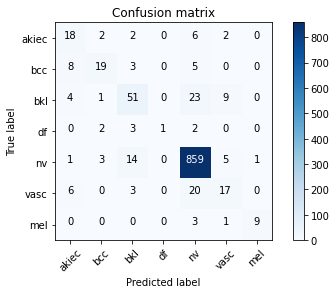

In [ ]:
### evaluation resnet 

modelR.eval()
y_label = []
y_predict = []
with torch.no_grad():
    for i, data in enumerate(val_loader):
        images, labels = data
        N = images.size(0)
        images = Variable(images).to(device)
        outputs = modelR(images)
        prediction = outputs.max(1, keepdim=True)[1]
        y_label.extend(labels.cpu().numpy())
        y_predict.extend(np.squeeze(prediction.cpu().numpy().T))

# compute the confusion matrix
confusion_mtx = confusion_matrix(y_label, y_predict)
# plot the confusion matrix
plot_labels = ['akiec', 'bcc', 'bkl', 'df', 'nv', 'vasc','mel']
plot_confusion_matrix(confusion_mtx, plot_labels)

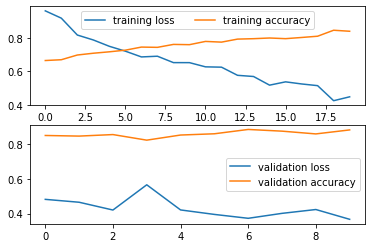

In [ ]:
fig = plt.figure(num = 2)
fig1 = fig.add_subplot(2,1,1)
fig2 = fig.add_subplot(2,1,2)
fig1.plot(total_loss_train, label = 'training loss')
fig1.plot(total_acc_train, label = 'training accuracy')
fig1.legend(loc='upper center', ncol=2)
fig2.plot(total_loss_val, label = 'validation loss')
fig2.plot(total_acc_val, label = 'validation accuracy')
fig2.legend()
plt.show()

In [ ]:
!pip install scikit-plot

In [ ]:
# Generate a classification report
report = classification_report(y_label, y_predict, target_names=plot_labels)
print(report)

              precision    recall  f1-score   support

       akiec       0.49      0.60      0.54        30
         bcc       0.70      0.54      0.61        35
         bkl       0.67      0.58      0.62        88
          df       1.00      0.12      0.22         8
          nv       0.94      0.97      0.95       883
        vasc       0.50      0.37      0.42        46
         mel       0.90      0.69      0.78        13

    accuracy                           0.88      1103
   macro avg       0.74      0.55      0.59      1103
weighted avg       0.88      0.88      0.88      1103



### VGG 

In [ ]:
############ next model is the vgg
# resnet,vgg,densenet,inception,mobilenet
model_nameVgg = 'vgg'
# Initialize the model for this run
model_ft2, input_size2 = initialize_model(model_nameVgg, num_classes, feature_extract, use_pretrained=True)
# Define the device:
device = torch.device('cuda:0')
# Put the model on the device:
modelVgg = model_ft2.to(device)

Downloading: "https://download.pytorch.org/models/vgg11_bn-6002323d.pth" to /root/.cache/torch/hub/checkpoints/vgg11_bn-6002323d.pth


  0%|          | 0.00/507M [00:00<?, ?B/s]

In [ ]:
optimizer = optim.Adam(modelVgg.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss().to(device)

total_loss_train, total_acc_train = [],[]

epoch_num = 10
best_val_acc = 0
total_loss_val, total_acc_val = [],[]
for epoch in range(1, epoch_num+1):
    loss_train, acc_train = train(train_loader, modelVgg, criterion, optimizer, epoch)
    loss_val, acc_val = validate(val_loader, modelVgg, criterion, optimizer, epoch)
    total_loss_val.append(loss_val)
    total_acc_val.append(acc_val)
    if acc_val > best_val_acc:
        best_val_acc = acc_val
        print('*****************************************************')
        print('best record: [epoch %d], [val loss %.5f], [val acc %.5f]' % (epoch, loss_val, acc_val))
        print('*****************************************************')

[epoch 1], [iter 100 / 279], [train loss 1.11579], [train acc 0.63187]
[epoch 1], [iter 200 / 279], [train loss 1.02179], [train acc 0.64516]
------------------------------------------------------------
[epoch 1], [val loss 0.79114], [val acc 0.82935]
------------------------------------------------------------
*****************************************************
best record: [epoch 1], [val loss 0.79114], [val acc 0.82935]
*****************************************************
[epoch 2], [iter 100 / 279], [train loss 0.94037], [train acc 0.67969]
[epoch 2], [iter 200 / 279], [train loss 0.95747], [train acc 0.67781]
------------------------------------------------------------
[epoch 2], [val loss 0.42839], [val acc 0.85524]
------------------------------------------------------------
*****************************************************
best record: [epoch 2], [val loss 0.42839], [val acc 0.85524]
*****************************************************
[epoch 3], [iter 100 / 279], [trai

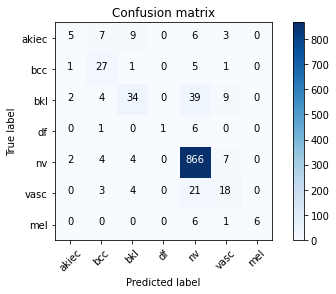

In [ ]:
### evaluation Vgg

modelVgg.eval()
y_label = []
y_predict = []
with torch.no_grad():
    for i, data in enumerate(val_loader):
        images, labels = data
        N = images.size(0)
        images = Variable(images).to(device)
        outputs = modelVgg(images)
        prediction = outputs.max(1, keepdim=True)[1]
        y_label.extend(labels.cpu().numpy())
        y_predict.extend(np.squeeze(prediction.cpu().numpy().T))

# compute the confusion matrix
confusion_mtx = confusion_matrix(y_label, y_predict)
# plot the confusion matrix
plot_labels = ['akiec', 'bcc', 'bkl', 'df', 'nv', 'vasc','mel']
plot_confusion_matrix(confusion_mtx, plot_labels)

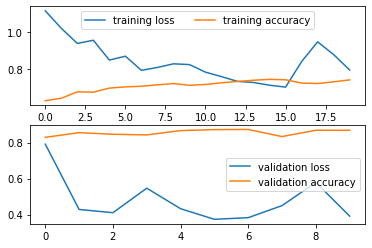

In [ ]:
fig = plt.figure(num = 2)
fig1 = fig.add_subplot(2,1,1)
fig2 = fig.add_subplot(2,1,2)
fig1.plot(total_loss_train, label = 'training loss')
fig1.plot(total_acc_train, label = 'training accuracy')
fig1.legend(loc='upper center', ncol=2)
fig2.plot(total_loss_val, label = 'validation loss')
fig2.plot(total_acc_val, label = 'validation accuracy')
fig2.legend()
plt.show()

In [ ]:
# Generate a classification report
report = classification_report(y_label, y_predict, target_names=plot_labels)
print(report)

              precision    recall  f1-score   support

       akiec       0.50      0.17      0.25        30
         bcc       0.59      0.77      0.67        35
         bkl       0.65      0.39      0.49        88
          df       1.00      0.12      0.22         8
          nv       0.91      0.98      0.95       883
        vasc       0.46      0.39      0.42        46
         mel       1.00      0.46      0.63        13

    accuracy                           0.87      1103
   macro avg       0.73      0.47      0.52      1103
weighted avg       0.85      0.87      0.85      1103



### Densnet 

In [ ]:
############ model densnet
# resnet,vgg,densenet,inception,mobilenet
model_nameDen = 'densenet'
# Initialize the model for this run
model_ft3, input_size3 = initialize_model(model_nameDen, num_classes, feature_extract, use_pretrained=True)
# Define the device:
device = torch.device('cuda:0')
# Put the model on the device:
modelDen = model_ft3.to(device)


###### training densnet 

optimizer = optim.Adam(modelDen.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss().to(device)

total_loss_train, total_acc_train = [],[]

epoch_num = 10
best_val_acc = 0
total_loss_val, total_acc_val = [],[]
for epoch in range(1, epoch_num+1):
    loss_train, acc_train = train(train_loader, modelDen, criterion, optimizer, epoch)
    loss_val, acc_val = validate(val_loader, modelDen, criterion, optimizer, epoch)
    total_loss_val.append(loss_val)
    total_acc_val.append(acc_val)
    if acc_val > best_val_acc:
        best_val_acc = acc_val
        print('*****************************************************')
        print('best record: [epoch %d], [val loss %.5f], [val acc %.5f]' % (epoch, loss_val, acc_val))
        print('*****************************************************')

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


  0%|          | 0.00/30.8M [00:00<?, ?B/s]

[epoch 1], [iter 100 / 279], [train loss 0.94791], [train acc 0.67156]
[epoch 1], [iter 200 / 279], [train loss 0.87507], [train acc 0.68766]
------------------------------------------------------------
[epoch 1], [val loss 0.40454], [val acc 0.86952]
------------------------------------------------------------
*****************************************************
best record: [epoch 1], [val loss 0.40454], [val acc 0.86952]
*****************************************************
[epoch 2], [iter 100 / 279], [train loss 0.71390], [train acc 0.73188]
[epoch 2], [iter 200 / 279], [train loss 0.70931], [train acc 0.73547]
------------------------------------------------------------
[epoch 2], [val loss 0.39715], [val acc 0.85958]
------------------------------------------------------------
[epoch 3], [iter 100 / 279], [train loss 0.67846], [train acc 0.75406]
[epoch 3], [iter 200 / 279], [train loss 0.65332], [train acc 0.76141]
------------------------------------------------------------
[

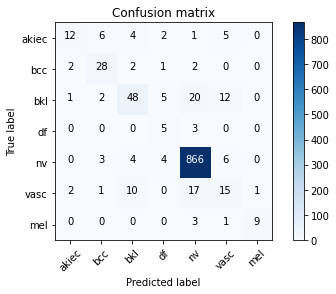

In [ ]:
### evaluation Densnet

modelDen.eval()
y_label = []
y_predict = []
with torch.no_grad():
    for i, data in enumerate(val_loader):
        images, labels = data
        N = images.size(0)
        images = Variable(images).to(device)
        outputs = modelDen(images)
        prediction = outputs.max(1, keepdim=True)[1]
        y_label.extend(labels.cpu().numpy())
        y_predict.extend(np.squeeze(prediction.cpu().numpy().T))

# compute the confusion matrix
confusion_mtx = confusion_matrix(y_label, y_predict)
# plot the confusion matrix
plot_labels = ['akiec', 'bcc', 'bkl', 'df', 'nv', 'vasc','mel']
plot_confusion_matrix(confusion_mtx, plot_labels)

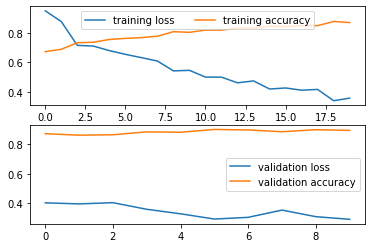

In [ ]:
fig = plt.figure(num = 2)
fig1 = fig.add_subplot(2,1,1)
fig2 = fig.add_subplot(2,1,2)
fig1.plot(total_loss_train, label = 'training loss')
fig1.plot(total_acc_train, label = 'training accuracy')
fig1.legend(loc='upper center', ncol=2)
fig2.plot(total_loss_val, label = 'validation loss')
fig2.plot(total_acc_val, label = 'validation accuracy')
fig2.legend()
plt.show()

In [ ]:
report = classification_report(y_label, y_predict, target_names=plot_labels)
print(report)

              precision    recall  f1-score   support

       akiec       0.71      0.40      0.51        30
         bcc       0.70      0.80      0.75        35
         bkl       0.71      0.55      0.62        88
          df       0.29      0.62      0.40         8
          nv       0.95      0.98      0.96       883
        vasc       0.38      0.33      0.35        46
         mel       0.90      0.69      0.78        13

    accuracy                           0.89      1103
   macro avg       0.66      0.62      0.62      1103
weighted avg       0.89      0.89      0.89      1103



### Inception

In [ ]:
input_size =299
train_transformI = transforms.Compose([transforms.Resize((input_size,input_size)),transforms.RandomHorizontalFlip(),
                                      transforms.RandomVerticalFlip(),transforms.RandomRotation(20),
                                      transforms.ColorJitter(brightness=0.1, contrast=0.1, hue=0.1),
                                        transforms.ToTensor(), transforms.Normalize(norm_mean, norm_std)])
# define the transformation of the val images.
val_transformI = transforms.Compose([transforms.Resize((input_size,input_size)), transforms.ToTensor(),
                                    transforms.Normalize(norm_mean, norm_std)])


# Define the training set using the table train_df and using our defined transitions (train_transform)
training_setI = HAM10000(df_train, transform=train_transformI)
train_loaderI = DataLoader(training_setI, batch_size=32, shuffle=True, num_workers=4)
# Same for the validation set:
validation_setI = HAM10000(df_val, transform=val_transformI)
val_loaderI = DataLoader(validation_setI, batch_size=32, shuffle=False, num_workers=4)

###### training inception 

In [ ]:
model_nameI = 'inception'
# Initialize the model for this run
num_classes = 7
feature_extract = False
model_ft, input_size = initialize_model(model_nameI,num_classes, feature_extract, use_pretrained=True)
# Define the device:
device = torch.device('cuda:0')
# Put the model on the device:
modelI = model_ft.to(device)


###### training densnet 

optimizer = optim.Adam(modelI.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss().to(device)

total_loss_train, total_acc_train = [],[]

epoch_num = 10
best_val_acc = 0
total_loss_val, total_acc_val = [],[]
for epoch in range(1, epoch_num+1):
    loss_train, acc_train = train(train_loaderI, modelI, criterion, optimizer, epoch)
    loss_val, acc_val = validate(val_loaderI, modelI, criterion, optimizer, epoch)
    total_loss_val.append(loss_val)
    total_acc_val.append(acc_val)
    if acc_val > best_val_acc:
        best_val_acc = acc_val
        print('*****************************************************')
        print('best record: [epoch %d], [val loss %.5f], [val acc %.5f]' % (epoch, loss_val, acc_val))
        print('***********************************')

Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth


  0%|          | 0.00/104M [00:00<?, ?B/s]

[epoch 1], [iter 100 / 279], [train loss 0.99888], [train acc 0.66406]
[epoch 1], [iter 200 / 279], [train loss 0.96849], [train acc 0.67031]
------------------------------------------------------------
[epoch 1], [val loss 0.51765], [val acc 0.84810]
------------------------------------------------------------
*****************************************************
best record: [epoch 1], [val loss 0.51765], [val acc 0.84810]
***********************************
[epoch 2], [iter 100 / 279], [train loss 0.89868], [train acc 0.69312]
[epoch 2], [iter 200 / 279], [train loss 0.88685], [train acc 0.69594]
------------------------------------------------------------
[epoch 2], [val loss 0.60304], [val acc 0.84542]
------------------------------------------------------------
[epoch 3], [iter 100 / 279], [train loss 0.85297], [train acc 0.69250]
[epoch 3], [iter 200 / 279], [train loss 0.83795], [train acc 0.70016]
------------------------------------------------------------
[epoch 3], [val los

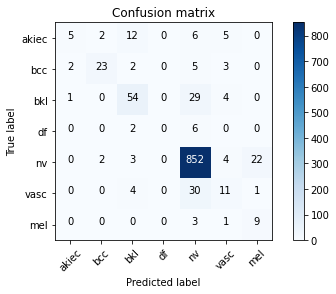

In [ ]:
modelI.eval()
y_label = []
y_predict = []
with torch.no_grad():
    for i, data in enumerate(val_loaderI):
        images, labels = data
        N = images.size(0)
        images = Variable(images).to(device)
        outputs = modelI(images)
        prediction = outputs.max(1, keepdim=True)[1]
        y_label.extend(labels.cpu().numpy())
        y_predict.extend(np.squeeze(prediction.cpu().numpy().T))

# compute the confusion matrix
confusion_mtx = confusion_matrix(y_label, y_predict)
# plot the confusion matrix
plot_labels = ['akiec', 'bcc', 'bkl', 'df', 'nv', 'vasc','mel']
plot_confusion_matrix(confusion_mtx, plot_labels)

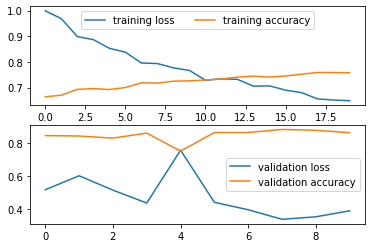

In [ ]:
fig = plt.figure(num = 2)
fig1 = fig.add_subplot(2,1,1)
fig2 = fig.add_subplot(2,1,2)
fig1.plot(total_loss_train, label = 'training loss')
fig1.plot(total_acc_train, label = 'training accuracy')
fig1.legend(loc='upper center', ncol=2)
fig2.plot(total_loss_val, label = 'validation loss')
fig2.plot(total_acc_val, label = 'validation accuracy')
fig2.legend()
plt.show()

In [ ]:
report = classification_report(y_label, y_predict, target_names=plot_labels)
print(report)

              precision    recall  f1-score   support

       akiec       0.62      0.17      0.26        30
         bcc       0.85      0.66      0.74        35
         bkl       0.70      0.61      0.65        88
          df       0.00      0.00      0.00         8
          nv       0.92      0.96      0.94       883
        vasc       0.39      0.24      0.30        46
         mel       0.28      0.69      0.40        13

    accuracy                           0.86      1103
   macro avg       0.54      0.48      0.47      1103
weighted avg       0.85      0.86      0.85      1103



### Mobilenet 

In [ ]:
# model mobilenet
model_nameM = 'mobilenet'
# Initialize the model for this run
model_ft5, input_size5 = initialize_model(model_nameM, num_classes, feature_extract, use_pretrained=True)
# Define the device:
device = torch.device('cuda:0')
# Put the model on the device:
modelM = model_ft5.to(device)


###### training mobilenet

optimizer = optim.Adam(modelM.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss().to(device)

total_loss_train, total_acc_train = [],[]

epoch_num = 10
best_val_acc = 0
total_loss_val, total_acc_val = [],[]
for epoch in range(1, epoch_num+1):
    loss_train, acc_train = train(train_loader, modelM, criterion, optimizer, epoch)
    loss_val, acc_val = validate(val_loader, modelM, criterion, optimizer, epoch)
    total_loss_val.append(loss_val)
    total_acc_val.append(acc_val)
    if acc_val > best_val_acc:
        best_val_acc = acc_val
        print('*****************************************************')
        print('best record: [epoch %d], [val loss %.5f], [val acc %.5f]' % (epoch, loss_val, acc_val))
        print('*****************************************************')


Downloading: "https://download.pytorch.org/models/mobilenet_v3_small-047dcff4.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_small-047dcff4.pth


  0%|          | 0.00/9.83M [00:00<?, ?B/s]

[epoch 1], [iter 100 / 279], [train loss 1.14508], [train acc 0.66875]
[epoch 1], [iter 200 / 279], [train loss 0.94247], [train acc 0.69797]
------------------------------------------------------------
[epoch 1], [val loss 0.37863], [val acc 0.88292]
------------------------------------------------------------
*****************************************************
best record: [epoch 1], [val loss 0.37863], [val acc 0.88292]
*****************************************************
[epoch 2], [iter 100 / 279], [train loss 0.52253], [train acc 0.80469]
[epoch 2], [iter 200 / 279], [train loss 0.53335], [train acc 0.80578]
------------------------------------------------------------
[epoch 2], [val loss 0.33782], [val acc 0.88202]
------------------------------------------------------------
[epoch 3], [iter 100 / 279], [train loss 0.37323], [train acc 0.86469]
[epoch 3], [iter 200 / 279], [train loss 0.40391], [train acc 0.85141]
------------------------------------------------------------
[

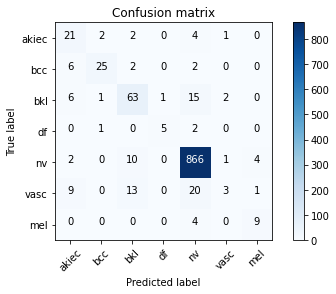

In [ ]:
modelM.eval()
y_label = []
y_predict = []
with torch.no_grad():
    for i, data in enumerate(val_loader):
        images, labels = data
        N = images.size(0)
        images = Variable(images).to(device)
        outputs = modelM(images)
        prediction = outputs.max(1, keepdim=True)[1]
        y_label.extend(labels.cpu().numpy())
        y_predict.extend(np.squeeze(prediction.cpu().numpy().T))

# compute the confusion matrix
confusion_mtx = confusion_matrix(y_label, y_predict)
# plot the confusion matrix
plot_labels = ['akiec', 'bcc', 'bkl', 'df', 'nv', 'vasc','mel']
plot_confusion_matrix(confusion_mtx, plot_labels)

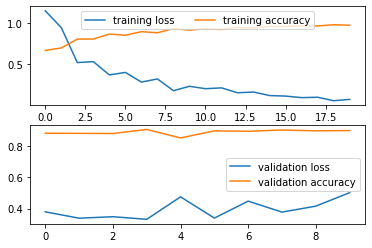

In [ ]:
fig = plt.figure(num = 2)
fig1 = fig.add_subplot(2,1,1)
fig2 = fig.add_subplot(2,1,2)
fig1.plot(total_loss_train, label = 'training loss')
fig1.plot(total_acc_train, label = 'training accuracy')
fig1.legend(loc='upper center', ncol=2)
fig2.plot(total_loss_val, label = 'validation loss')
fig2.plot(total_acc_val, label = 'validation accuracy')
fig2.legend()
plt.show()

In [ ]:
report = classification_report(y_label, y_predict, target_names=plot_labels)
print(report)

              precision    recall  f1-score   support

       akiec       0.48      0.70      0.57        30
         bcc       0.86      0.71      0.78        35
         bkl       0.70      0.72      0.71        88
          df       0.83      0.62      0.71         8
          nv       0.95      0.98      0.96       883
        vasc       0.43      0.07      0.11        46
         mel       0.64      0.69      0.67        13

    accuracy                           0.90      1103
   macro avg       0.70      0.64      0.65      1103
weighted avg       0.89      0.90      0.89      1103



## Focal loss 

In [ ]:
train_transform = transforms.Compose([transforms.Resize((input_size,input_size)),transforms.RandomHorizontalFlip(),
                                      transforms.RandomVerticalFlip(),transforms.RandomRotation(20),
                                      transforms.ColorJitter(brightness=0.1, contrast=0.1, hue=0.1),
                                        transforms.ToTensor(), transforms.Normalize(norm_mean, norm_std)])
# define the transformation of the val images.
val_transform = transforms.Compose([transforms.Resize((input_size,input_size)), transforms.ToTensor(),
                                    transforms.Normalize(norm_mean, norm_std)])


# Define the training set using the table train_df and using our defined transitions (train_transform)
training_set = HAM10000(df_train, transform=train_transform)
train_loader = DataLoader(training_set, batch_size=32, shuffle=True, num_workers=4)
# Same for the validation set:
validation_set = HAM10000(df_val, transform=val_transform)
val_loader = DataLoader(validation_set, batch_size=32, shuffle=False, num_workers=4)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class FocalLoss(nn.modules.loss._WeightedLoss):
    def __init__(self, weight=None, gamma=2,reduction='none', alpha = 0.25):
        super(FocalLoss, self).__init__(weight,reduction=reduction)
        self.gamma = gamma
        self.weight = weight #weight parameter will act as the alpha parameter to balance class weights
        self.alpha = alpha
    def forward(self, input, target):
       
        #ce_loss = F.cross_entropy(input, target, reduction='none') # important to add reduction='none' to keep per-batch-item loss
       # pt = torch.exp(-ce_loss)
       # 
        ce_loss = F.cross_entropy(input, target,reduction='none',weight=self.weight)
        pt = torch.exp(-ce_loss)
        #focal_loss = ((1 - pt) ** self.gamma * ce_loss).mean()
        focal_loss = (self.alpha * (1-pt)** self.gamma * ce_loss).mean()
        return focal_loss
   

### Resnet


In [ ]:
model_name = 'resnet'
num_classes = 7
feature_extract = False
# Initialize the model for this run
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)
# Define the device:
device = torch.device('cuda:0')
# Put the model on the device:
modelRF = model_ft.to(device)

In [ ]:
# we use Adam optimizer, use cross entropy loss as our loss function
optimizer = optim.Adam(modelRF.parameters(), lr=1e-3)
criterion = FocalLoss()#.to(device)#nn.CrossEntropyLoss().to(device)

In [ ]:
##### training resnet 
epoch_num = 10
best_val_acc = 0
total_loss_val, total_acc_val = [],[]
for epoch in range(1, epoch_num+1):
    loss_train, acc_train = train(train_loader, modelRF, criterion, optimizer, epoch)
    loss_val, acc_val = validate(val_loader, modelRF, criterion, optimizer, epoch)
    total_loss_val.append(loss_val)
    total_acc_val.append(acc_val)
    if acc_val > best_val_acc:
        best_val_acc = acc_val
        print('*****************************************************')
        print('best record: [epoch %d], [val loss %.5f], [val acc %.5f]' % (epoch, loss_val, acc_val))
        print('*****************************************************')

[epoch 1], [iter 100 / 279], [train loss 0.17263], [train acc 0.64187]
[epoch 1], [iter 200 / 279], [train loss 0.15944], [train acc 0.64984]
------------------------------------------------------------
[epoch 1], [val loss 0.07759], [val acc 0.82220]
------------------------------------------------------------
*****************************************************
best record: [epoch 1], [val loss 0.07759], [val acc 0.82220]
*****************************************************
[epoch 2], [iter 100 / 279], [train loss 0.13327], [train acc 0.65719]
[epoch 2], [iter 200 / 279], [train loss 0.13259], [train acc 0.66391]
------------------------------------------------------------
[epoch 2], [val loss 0.09090], [val acc 0.80690]
------------------------------------------------------------
[epoch 3], [iter 100 / 279], [train loss 0.13135], [train acc 0.67281]
[epoch 3], [iter 200 / 279], [train loss 0.12513], [train acc 0.68125]
------------------------------------------------------------
[

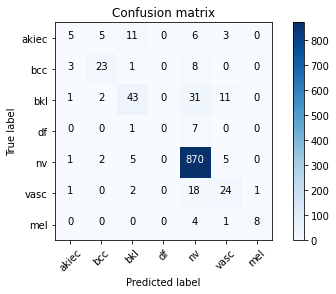

In [ ]:
### evaluation resnet 

modelRF.eval()
y_label = []
y_predict = []
with torch.no_grad():
    for i, data in enumerate(val_loader):
        images, labels = data
        N = images.size(0)
        images = Variable(images).to(device)
        outputs = modelRF(images)
        prediction = outputs.max(1, keepdim=True)[1]
        y_label.extend(labels.cpu().numpy())
        y_predict.extend(np.squeeze(prediction.cpu().numpy().T))

# compute the confusion matrix
confusion_mtx = confusion_matrix(y_label, y_predict)
# plot the confusion matrix
plot_labels = ['akiec', 'bcc', 'bkl', 'df', 'nv', 'vasc','mel']
plot_confusion_matrix(confusion_mtx, plot_labels)

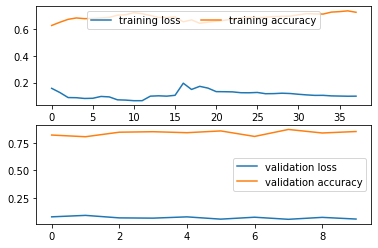

In [ ]:
fig = plt.figure(num = 2)
fig1 = fig.add_subplot(2,1,1)
fig2 = fig.add_subplot(2,1,2)
fig1.plot(total_loss_train, label = 'training loss')
fig1.plot(total_acc_train, label = 'training accuracy')
fig1.legend(loc='upper center', ncol=2)
fig2.plot(total_loss_val, label = 'validation loss')
fig2.plot(total_acc_val, label = 'validation accuracy')
fig2.legend()
plt.show()

In [ ]:
report = classification_report(y_label, y_predict, target_names=plot_labels)
print(report)

              precision    recall  f1-score   support

       akiec       0.45      0.17      0.24        30
         bcc       0.72      0.66      0.69        35
         bkl       0.68      0.49      0.57        88
          df       0.00      0.00      0.00         8
          nv       0.92      0.99      0.95       883
        vasc       0.55      0.52      0.53        46
         mel       0.89      0.62      0.73        13

    accuracy                           0.88      1103
   macro avg       0.60      0.49      0.53      1103
weighted avg       0.86      0.88      0.87      1103



### Vgg 

In [ ]:
############ next model is the vgg
# resnet,vgg,densenet,inception,mobilenet
model_nameVgg = 'vgg'
# Initialize the model for this run
model_ft2, input_size2 = initialize_model(model_nameVgg, num_classes, feature_extract, use_pretrained=True)
# Define the device:
device = torch.device('cuda:0')
# Put the model on the device:
modelVgg = model_ft2.to(device)

In [ ]:
# we use Adam optimizer, use cross entropy loss as our loss function
optimizer = optim.Adam(modelVgg.parameters(), lr=1e-3)
criterion = FocalLoss()

In [ ]:

total_loss_train, total_acc_train = [],[]

epoch_num = 10
best_val_acc = 0
total_loss_val, total_acc_val = [],[]
for epoch in range(1, epoch_num+1):
    loss_train, acc_train = train(train_loader, modelVgg, criterion, optimizer, epoch)
    loss_val, acc_val = validate(val_loader, modelVgg, criterion, optimizer, epoch)
    total_loss_val.append(loss_val)
    total_acc_val.append(acc_val)
    if acc_val > best_val_acc:
        best_val_acc = acc_val
        print('*****************************************************')
        print('best record: [epoch %d], [val loss %.5f], [val acc %.5f]' % (epoch, loss_val, acc_val))
        print('*****************************************************')

[epoch 1], [iter 100 / 279], [train loss 0.19185], [train acc 0.64250]
[epoch 1], [iter 200 / 279], [train loss 0.18351], [train acc 0.64563]
------------------------------------------------------------
[epoch 1], [val loss 0.09801], [val acc 0.80256]
------------------------------------------------------------
*****************************************************
best record: [epoch 1], [val loss 0.09801], [val acc 0.80256]
*****************************************************
[epoch 2], [iter 100 / 279], [train loss 0.17074], [train acc 0.65375]
[epoch 2], [iter 200 / 279], [train loss 0.16331], [train acc 0.65500]
------------------------------------------------------------
[epoch 2], [val loss 0.08627], [val acc 0.81060]
------------------------------------------------------------
*****************************************************
best record: [epoch 2], [val loss 0.08627], [val acc 0.81060]
*****************************************************
[epoch 3], [iter 100 / 279], [trai

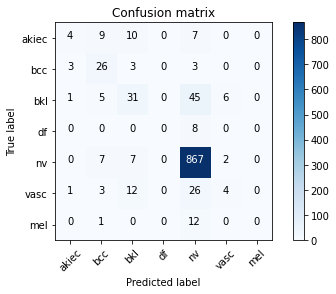

In [ ]:
### evaluation Vgg

modelVgg.eval()
y_label = []
y_predict = []
with torch.no_grad():
    for i, data in enumerate(val_loader):
        images, labels = data
        N = images.size(0)
        images = Variable(images).to(device)
        outputs = modelVgg(images)
        prediction = outputs.max(1, keepdim=True)[1]
        y_label.extend(labels.cpu().numpy())
        y_predict.extend(np.squeeze(prediction.cpu().numpy().T))

# compute the confusion matrix
confusion_mtx = confusion_matrix(y_label, y_predict)
# plot the confusion matrix
plot_labels = ['akiec', 'bcc', 'bkl', 'df', 'nv', 'vasc','mel']
plot_confusion_matrix(confusion_mtx, plot_labels)

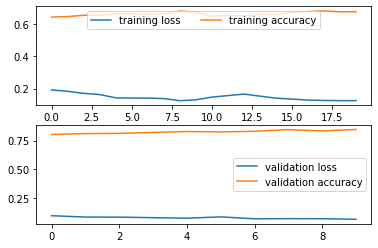

In [ ]:
fig = plt.figure(num = 2)
fig1 = fig.add_subplot(2,1,1)
fig2 = fig.add_subplot(2,1,2)
fig1.plot(total_loss_train, label = 'training loss')
fig1.plot(total_acc_train, label = 'training accuracy')
fig1.legend(loc='upper center', ncol=2)
fig2.plot(total_loss_val, label = 'validation loss')
fig2.plot(total_acc_val, label = 'validation accuracy')
fig2.legend()
plt.show()

In [ ]:
# Generate a classification report
report = classification_report(y_label, y_predict, target_names=plot_labels)
print(report)

              precision    recall  f1-score   support

       akiec       0.44      0.13      0.21        30
         bcc       0.51      0.74      0.60        35
         bkl       0.49      0.35      0.41        88
          df       0.00      0.00      0.00         8
          nv       0.90      0.98      0.94       883
        vasc       0.33      0.09      0.14        46
         mel       0.00      0.00      0.00        13

    accuracy                           0.84      1103
   macro avg       0.38      0.33      0.33      1103
weighted avg       0.80      0.84      0.81      1103



### Densnet 

In [ ]:
############ model densnet
# resnet,vgg,densenet,inception,mobilenet
model_nameDen = 'densenet'
# Initialize the model for this run
model_ft3, input_size3 = initialize_model(model_nameDen, num_classes, feature_extract, use_pretrained=True)
# Define the device:
device = torch.device('cuda:0')
# Put the model on the device:
modelDen = model_ft3.to(device)


###### training densnet 

optimizer = optim.Adam(modelDen.parameters(), lr=1e-3)
criterion = FocalLoss()

total_loss_train, total_acc_train = [],[]

epoch_num = 10
best_val_acc = 0
total_loss_val, total_acc_val = [],[]
for epoch in range(1, epoch_num+1):
    loss_train, acc_train = train(train_loader, modelDen, criterion, optimizer, epoch)
    loss_val, acc_val = validate(val_loader, modelDen, criterion, optimizer, epoch)
    total_loss_val.append(loss_val)
    total_acc_val.append(acc_val)
    if acc_val > best_val_acc:
        best_val_acc = acc_val
        print('*****************************************************')
        print('best record: [epoch %d], [val loss %.5f], [val acc %.5f]' % (epoch, loss_val, acc_val))
        print('*****************************************************')

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


  0%|          | 0.00/30.8M [00:00<?, ?B/s]

[epoch 1], [iter 100 / 279], [train loss 0.14617], [train acc 0.66750]
[epoch 1], [iter 200 / 279], [train loss 0.13790], [train acc 0.66844]
------------------------------------------------------------
[epoch 1], [val loss 0.22044], [val acc 0.41244]
------------------------------------------------------------
*****************************************************
best record: [epoch 1], [val loss 0.22044], [val acc 0.41244]
*****************************************************
[epoch 2], [iter 100 / 279], [train loss 0.11758], [train acc 0.68812]
[epoch 2], [iter 200 / 279], [train loss 0.11314], [train acc 0.70094]
------------------------------------------------------------
[epoch 2], [val loss 0.06268], [val acc 0.85155]
------------------------------------------------------------
*****************************************************
best record: [epoch 2], [val loss 0.06268], [val acc 0.85155]
*****************************************************
[epoch 3], [iter 100 / 279], [trai

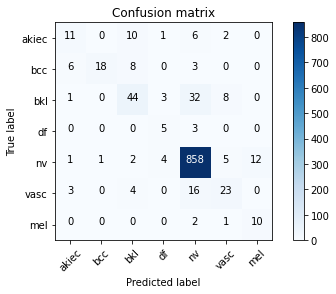

In [ ]:
### evaluation Densnet
modelDen.eval()
y_label = []
y_predict = []
with torch.no_grad():
    for i, data in enumerate(val_loader):
        images, labels = data
        N = images.size(0)
        images = Variable(images).to(device)
        outputs = modelDen(images)
        prediction = outputs.max(1, keepdim=True)[1]
        y_label.extend(labels.cpu().numpy())
        y_predict.extend(np.squeeze(prediction.cpu().numpy().T))

# compute the confusion matrix
confusion_mtx = confusion_matrix(y_label, y_predict)
# plot the confusion matrix
plot_labels = ['akiec', 'bcc', 'bkl', 'df', 'nv', 'vasc','mel']
plot_confusion_matrix(confusion_mtx, plot_labels)

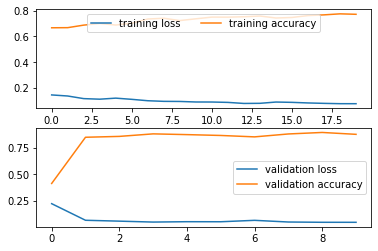

In [ ]:
fig = plt.figure(num = 2)
fig1 = fig.add_subplot(2,1,1)
fig2 = fig.add_subplot(2,1,2)
fig1.plot(total_loss_train, label = 'training loss')
fig1.plot(total_acc_train, label = 'training accuracy')
fig1.legend(loc='upper center', ncol=2)
fig2.plot(total_loss_val, label = 'validation loss')
fig2.plot(total_acc_val, label = 'validation accuracy')
fig2.legend()
plt.show()

In [ ]:
report = classification_report(y_label, y_predict, target_names=plot_labels)
print(report)

              precision    recall  f1-score   support

       akiec       0.50      0.37      0.42        30
         bcc       0.95      0.51      0.67        35
         bkl       0.65      0.50      0.56        88
          df       0.38      0.62      0.48         8
          nv       0.93      0.97      0.95       883
        vasc       0.59      0.50      0.54        46
         mel       0.45      0.77      0.57        13

    accuracy                           0.88      1103
   macro avg       0.64      0.61      0.60      1103
weighted avg       0.87      0.88      0.87      1103



### incerption 

In [ ]:
input_size =299
train_transformI = transforms.Compose([transforms.Resize((input_size,input_size)),transforms.RandomHorizontalFlip(),
                                      transforms.RandomVerticalFlip(),transforms.RandomRotation(20),
                                      transforms.ColorJitter(brightness=0.1, contrast=0.1, hue=0.1),
                                        transforms.ToTensor(), transforms.Normalize(norm_mean, norm_std)])
# define the transformation of the val images.
val_transformI = transforms.Compose([transforms.Resize((input_size,input_size)), transforms.ToTensor(),
                                    transforms.Normalize(norm_mean, norm_std)])


# Define the training set using the table train_df and using our defined transitions (train_transform)
training_setI = HAM10000(df_train, transform=train_transformI)
train_loaderI = DataLoader(training_setI, batch_size=32, shuffle=True, num_workers=4)
# Same for the validation set:
validation_setI = HAM10000(df_val, transform=val_transformI)
val_loaderI = DataLoader(validation_setI, batch_size=32, shuffle=False, num_workers=4)

###### training inception 

In [ ]:
model_nameI = 'inception'
# Initialize the model for this run
num_classes = 7
feature_extract = False
model_ft, input_size = initialize_model(model_nameI,num_classes, feature_extract, use_pretrained=True)
# Define the device:
device = torch.device('cuda:0')
# Put the model on the device:
modelI = model_ft.to(device)


###### training densnet 

optimizer = optim.Adam(modelI.parameters(), lr=1e-3)
criterion = FocalLoss()

total_loss_train, total_acc_train = [],[]

epoch_num = 10
best_val_acc = 0
total_loss_val, total_acc_val = [],[]
for epoch in range(1, epoch_num+1):
    loss_train, acc_train = train(train_loaderI, modelI, criterion, optimizer, epoch)
    loss_val, acc_val = validate(val_loaderI, modelI, criterion, optimizer, epoch)
    total_loss_val.append(loss_val)
    total_acc_val.append(acc_val)
    if acc_val > best_val_acc:
        best_val_acc = acc_val
        print('*****************************************************')
        print('best record: [epoch %d], [val loss %.5f], [val acc %.5f]' % (epoch, loss_val, acc_val))
        print('***********************************')

[epoch 1], [iter 100 / 279], [train loss 0.15568], [train acc 0.64469]
[epoch 1], [iter 200 / 279], [train loss 0.14286], [train acc 0.66203]
------------------------------------------------------------
[epoch 1], [val loss 0.06696], [val acc 0.84899]
------------------------------------------------------------
*****************************************************
best record: [epoch 1], [val loss 0.06696], [val acc 0.84899]
***********************************
[epoch 2], [iter 100 / 279], [train loss 0.11435], [train acc 0.69437]
[epoch 2], [iter 200 / 279], [train loss 0.11662], [train acc 0.69328]
------------------------------------------------------------
[epoch 2], [val loss 0.06558], [val acc 0.85256]
------------------------------------------------------------
*****************************************************
best record: [epoch 2], [val loss 0.06558], [val acc 0.85256]
***********************************
[epoch 3], [iter 100 / 279], [train loss 0.11110], [train acc 0.69875]

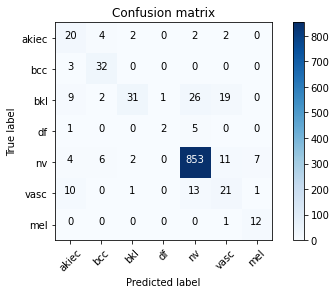

In [ ]:
modelI.eval()
y_label = []
y_predict = []
with torch.no_grad():
    for i, data in enumerate(val_loaderI):
        images, labels = data
        N = images.size(0)
        images = Variable(images).to(device)
        outputs = modelI(images)
        prediction = outputs.max(1, keepdim=True)[1]
        y_label.extend(labels.cpu().numpy())
        y_predict.extend(np.squeeze(prediction.cpu().numpy().T))

# compute the confusion matrix
confusion_mtx = confusion_matrix(y_label, y_predict)
# plot the confusion matrix
plot_labels = ['akiec', 'bcc', 'bkl', 'df', 'nv', 'vasc','mel']
plot_confusion_matrix(confusion_mtx, plot_labels)

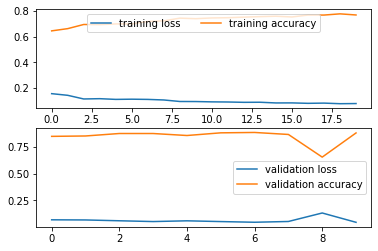

In [ ]:
fig = plt.figure(num = 2)
fig1 = fig.add_subplot(2,1,1)
fig2 = fig.add_subplot(2,1,2)
fig1.plot(total_loss_train, label = 'training loss')
fig1.plot(total_acc_train, label = 'training accuracy')
fig1.legend(loc='upper center', ncol=2)
fig2.plot(total_loss_val, label = 'validation loss')
fig2.plot(total_acc_val, label = 'validation accuracy')
fig2.legend()
plt.show()

In [ ]:
# Generate a classification report
report = classification_report(y_label, y_predict, target_names=plot_labels)
print(report)

              precision    recall  f1-score   support

       akiec       0.43      0.67      0.52        30
         bcc       0.73      0.91      0.81        35
         bkl       0.86      0.35      0.50        88
          df       0.67      0.25      0.36         8
          nv       0.95      0.97      0.96       883
        vasc       0.39      0.46      0.42        46
         mel       0.60      0.92      0.73        13

    accuracy                           0.88      1103
   macro avg       0.66      0.65      0.61      1103
weighted avg       0.89      0.88      0.87      1103



### Mobilenet 


In [ ]:
# model mobilenet
model_nameM = 'mobilenet'
# Initialize the model for this run
model_ft5, input_size5 = initialize_model(model_nameM, num_classes, feature_extract, use_pretrained=True)
# Define the device:
device = torch.device('cuda:0')
# Put the model on the device:
modelM = model_ft5.to(device)


###### training mobilenet

optimizer = optim.Adam(modelM.parameters(), lr=1e-3)
criterion = FocalLoss()

total_loss_train, total_acc_train = [],[]

epoch_num = 10
best_val_acc = 0
total_loss_val, total_acc_val = [],[]
for epoch in range(1, epoch_num+1):
    loss_train, acc_train = train(train_loader, modelM, criterion, optimizer, epoch)
    loss_val, acc_val = validate(val_loader, modelM, criterion, optimizer, epoch)
    total_loss_val.append(loss_val)
    total_acc_val.append(acc_val)
    if acc_val > best_val_acc:
        best_val_acc = acc_val
        print('*****************************************************')
        print('best record: [epoch %d], [val loss %.5f], [val acc %.5f]' % (epoch, loss_val, acc_val))
        print('*****************************************************')


Downloading: "https://download.pytorch.org/models/mobilenet_v3_small-047dcff4.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_small-047dcff4.pth


  0%|          | 0.00/9.83M [00:00<?, ?B/s]

[epoch 1], [iter 100 / 279], [train loss 0.22856], [train acc 0.64531]
[epoch 1], [iter 200 / 279], [train loss 0.17885], [train acc 0.66156]
------------------------------------------------------------
[epoch 1], [val loss 0.06923], [val acc 0.84810]
------------------------------------------------------------
*****************************************************
best record: [epoch 1], [val loss 0.06923], [val acc 0.84810]
*****************************************************
[epoch 2], [iter 100 / 279], [train loss 0.10738], [train acc 0.71437]
[epoch 2], [iter 200 / 279], [train loss 0.09841], [train acc 0.73109]
------------------------------------------------------------
[epoch 2], [val loss 0.06115], [val acc 0.85881]
------------------------------------------------------------
*****************************************************
best record: [epoch 2], [val loss 0.06115], [val acc 0.85881]
*****************************************************
[epoch 3], [iter 100 / 279], [trai

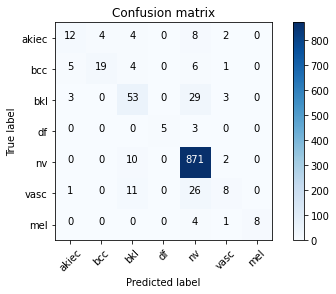

In [ ]:
modelM.eval()
y_label = []
y_predict = []
with torch.no_grad():
    for i, data in enumerate(val_loader):
        images, labels = data
        N = images.size(0)
        images = Variable(images).to(device)
        outputs = modelM(images)
        prediction = outputs.max(1, keepdim=True)[1]
        y_label.extend(labels.cpu().numpy())
        y_predict.extend(np.squeeze(prediction.cpu().numpy().T))

# compute the confusion matrix
confusion_mtx = confusion_matrix(y_label, y_predict)
# plot the confusion matrix
plot_labels = ['akiec', 'bcc', 'bkl', 'df', 'nv', 'vasc','mel']
plot_confusion_matrix(confusion_mtx, plot_labels)

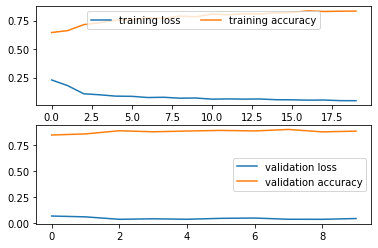

In [ ]:
fig = plt.figure(num = 2)
fig1 = fig.add_subplot(2,1,1)
fig2 = fig.add_subplot(2,1,2)
fig1.plot(total_loss_train, label = 'training loss')
fig1.plot(total_acc_train, label = 'training accuracy')
fig1.legend(loc='upper center', ncol=2)
fig2.plot(total_loss_val, label = 'validation loss')
fig2.plot(total_acc_val, label = 'validation accuracy')
fig2.legend()
plt.show()

In [ ]:
report = classification_report(y_label, y_predict, target_names=plot_labels)
print(report)

              precision    recall  f1-score   support

       akiec       0.57      0.40      0.47        30
         bcc       0.83      0.54      0.66        35
         bkl       0.65      0.60      0.62        88
          df       1.00      0.62      0.77         8
          nv       0.92      0.99      0.95       883
        vasc       0.47      0.17      0.25        46
         mel       1.00      0.62      0.76        13

    accuracy                           0.88      1103
   macro avg       0.78      0.56      0.64      1103
weighted avg       0.87      0.88      0.87      1103

